# Photodiode Bandwidth Response Example

This notebook demonstrates how the finite bandwidth of a photodiode (PD) and amplifier system affects the shape of optical pulses.

## Key Concepts:
- **True optical signal**: A symmetric Gaussian pulse representing the actual Fabry-Pérot (FP) peak
- **PD + Amplifier response**: Modeled as a first-order RC low-pass filter with time constant τ
- **Measured signal**: The convolution of the true signal with the system's impulse response

## Physical Effect:
The finite electrical bandwidth causes:
- **Fast rise time**: Limited by the optical pulse duration
- **Slow decay**: Limited by the RC time constant of the electronics
- **Asymmetric peak shape**: The measured signal becomes skewed compared to the true symmetric peak

This is important for understanding systematic effects in precision optical measurements.

## Simulation Parameters

### Time Domain Setup:
- **Time window**: -20 to 80 μs (100 μs total) with 2000 points
- **Time resolution**: ~50 ns per point (sufficient for μs-scale features)

### Optical Pulse Parameters:
- **Pulse center (t₀)**: 10 μs - when the optical pulse peaks
- **Pulse width (σ)**: 3 μs - standard deviation of Gaussian pulse
- **FWHM**: ~7 μs (≈ 2.35σ) - full width at half maximum of the optical pulse

### Electronic System Parameters (Multiple RC Time Constants):
We compare four different photodiode/amplifier systems:

| τ (μs) | Bandwidth (kHz) | Rise Time (μs) | System Type |
|--------|-----------------|----------------|-------------|
| 0.32   | 500            | ~0.7          | Very fast   |
| 1.06   | 150            | ~2.3          | Fast system |
| 3.18   | 50             | ~7.0          | Medium      |
| 15.9   | 10             | ~35           | Slow system |

This range shows how bandwidth affects pulse fidelity, from minimal distortion (500 kHz) to severe distortion (10 kHz).

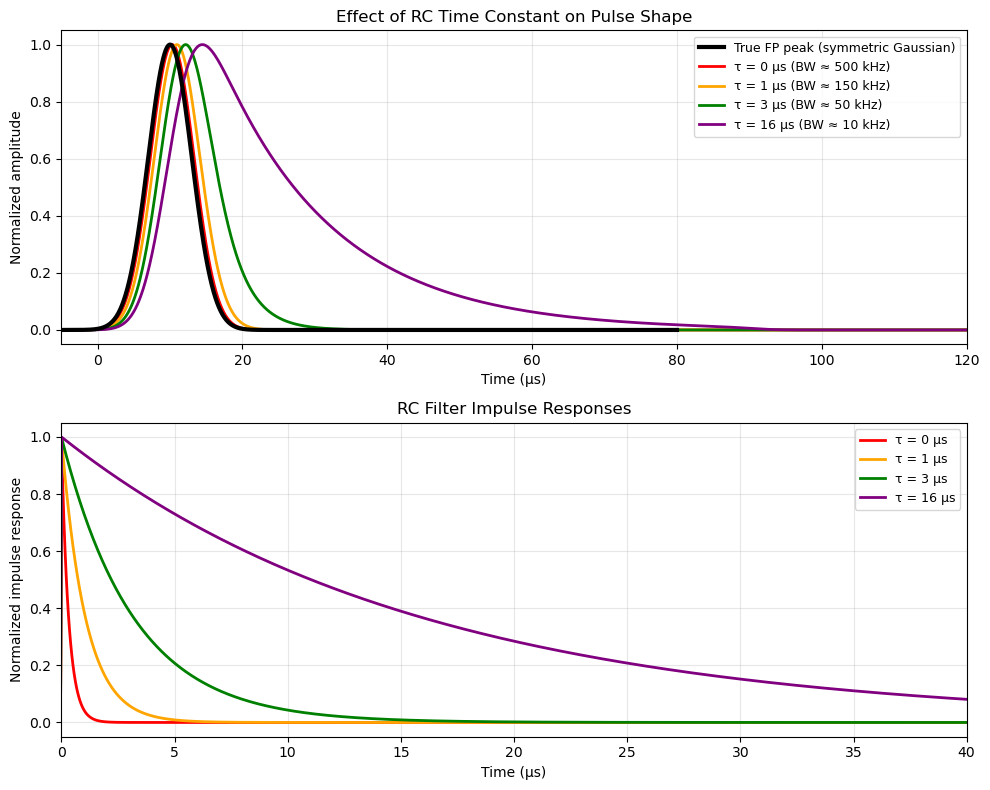

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Create the "true" Fabry-Pérot peak: symmetric Gaussian pulse
# Time axis: sufficient range to see pulse and decay response
t = np.linspace(-20e-6, 80e-6, 2000)  # 100 μs window, 50 ns resolution

# Optical pulse parameters
t0 = 10e-6        # Pulse center time [s] - when FP resonance peaks
sigma = 3e-6      # Gaussian width parameter [s] - controls pulse duration
                  # FWHM = 2.35 × σ ≈ 7 μs (typical for cavity scan)

# Generate symmetric Gaussian pulse: A(t) = exp(-(t-t0)²/(2σ²))
true_peak = np.exp(-(t - t0)**2/(2*sigma**2))

# 2. Compare different RC time constants to show bandwidth effects
# Different photodiode/amplifier systems with varying bandwidths
# Target bandwidths: 500, 150, 50, 10 kHz
# Calculate corresponding tau values: tau = 1/(2*pi*f_3dB)
tau_values = [1/(2*np.pi*500e3), 1/(2*np.pi*150e3), 1/(2*np.pi*50e3), 1/(2*np.pi*10e3)]  # RC time constants [s]
colors = ['red', 'orange', 'green', 'purple']
labels = []

# Calculate time step for convolution scaling
dt = t[1] - t[0]

# 3. Create subplot figure for better comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot 1: Overlay all responses
ax1.plot(t*1e6, true_peak, 'k-', linewidth=3, 
         label="True FP peak (symmetric Gaussian)", zorder=10)

# Loop through different time constants
for i, tau in enumerate(tau_values):
    # Calculate bandwidth and rise time for this tau
    bandwidth_khz = 1/(2*np.pi*tau) / 1000  # Convert to kHz
    rise_time_us = 2.2*tau * 1e6            # Convert to μs
    
    # Create impulse response: h(t) = (1/τ) × exp(-t/τ) × u(t)
    u = (t >= 0).astype(float)              # Unit step function
    h = (1/tau) * np.exp(-t/tau) * u        # RC impulse response
    
    # Convolve optical signal with electrical response
    meas = np.convolve(true_peak, h, mode='full') * dt
    t_meas = np.linspace(t[0]+t[0], t[-1]+t[-1], meas.size)
    
    # Plot normalized response
    label = f"τ = {tau*1e6:.0f} μs (BW ≈ {bandwidth_khz:.0f} kHz)"
    ax1.plot(t_meas*1e6, meas/np.max(meas), color=colors[i], 
             linewidth=2, label=label)

ax1.set_xlabel("Time (μs)")
ax1.set_ylabel("Normalized amplitude")
ax1.set_title("Effect of RC Time Constant on Pulse Shape")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-5, 120)

# Plot 2: Show impulse responses
ax2.set_title("RC Filter Impulse Responses")
for i, tau in enumerate(tau_values):
    u = (t >= 0).astype(float)
    h = (1/tau) * np.exp(-t/tau) * u
    ax2.plot(t*1e6, h*tau, color=colors[i], linewidth=2,
             label=f"τ = {tau*1e6:.0f} μs")

ax2.set_xlabel("Time (μs)")
ax2.set_ylabel("Normalized impulse response")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 40)

plt.tight_layout()

In [8]:
# 5. Analyze optical pulse frequency characteristics
print("=== OPTICAL PULSE FREQUENCY ANALYSIS ===\n")

# Time domain parameters
print("Time Domain Parameters:")
print(f"  Pulse width (σ): {sigma*1e6:.1f} μs")
print(f"  FWHM: {2.35*sigma*1e6:.1f} μs")
print(f"  Pulse duration (4σ): {4*sigma*1e6:.1f} μs")

# Frequency domain analysis using Fourier transform uncertainty principle
# For Gaussian pulse: Δt × Δf ≥ 1/(4π), with equality for Gaussian
print(f"\nFrequency Domain Characteristics:")

# Time-bandwidth product for Gaussian pulse
delta_t = sigma  # RMS time width
delta_f = 1/(4*np.pi*delta_t)  # RMS frequency width (minimum uncertainty)

print(f"  RMS time width (Δt): {delta_t*1e6:.1f} μs")
print(f"  RMS frequency width (Δf): {delta_f/1000:.1f} kHz")

# FWHM frequency width (more practical measure)
fwhm_freq = 2.35 * delta_f  # FWHM frequency width
print(f"  FWHM frequency width: {fwhm_freq/1000:.1f} kHz")

# Equivalent 3dB bandwidth (engineering convention)
bandwidth_3db = 0.44 / (sigma)  # Empirical factor for Gaussian pulse
print(f"  Equivalent 3dB bandwidth: {bandwidth_3db/1000:.1f} kHz")

print(f"\nComparison with Electronic Bandwidths:")
print(f"  Optical pulse bandwidth: {bandwidth_3db/1000:.1f} kHz")
for i, tau in enumerate(tau_values):
    elec_bw = 1/(2*np.pi*tau) / 1000
    ratio = elec_bw / (bandwidth_3db/1000)
    status = "FAST" if ratio > 3 else "MEDIUM" if ratio > 1 else "SLOW"
    print(f"  τ = {tau*1e6:2.0f} μs system: {elec_bw:4.0f} kHz (×{ratio:.1f} optical BW) - {status}")

print(f"\nDesign Guidelines:")
print(f"  • Electronics BW > 3× optical BW: minimal distortion")
print(f"  • Electronics BW ≈ optical BW: noticeable distortion") 
print(f"  • Electronics BW < optical BW: significant distortion")

=== OPTICAL PULSE FREQUENCY ANALYSIS ===

Time Domain Parameters:
  Pulse width (σ): 3.0 μs
  FWHM: 7.0 μs
  Pulse duration (4σ): 12.0 μs

Frequency Domain Characteristics:
  RMS time width (Δt): 3.0 μs
  RMS frequency width (Δf): 26.5 kHz
  FWHM frequency width: 62.3 kHz
  Equivalent 3dB bandwidth: 146.7 kHz

Comparison with Electronic Bandwidths:
  Optical pulse bandwidth: 146.7 kHz
  τ =  0 μs system:  500 kHz (×3.4 optical BW) - FAST
  τ =  1 μs system:  150 kHz (×1.0 optical BW) - MEDIUM
  τ =  3 μs system:   50 kHz (×0.3 optical BW) - SLOW
  τ = 16 μs system:   10 kHz (×0.1 optical BW) - SLOW

Design Guidelines:
  • Electronics BW > 3× optical BW: minimal distortion
  • Electronics BW ≈ optical BW: noticeable distortion
  • Electronics BW < optical BW: significant distortion


## Optical Pulse Frequency Analysis

For any pulse, there's a fundamental **time-bandwidth relationship**: shorter pulses require wider frequency bandwidth.

### Key Results:
- **Optical pulse bandwidth**: ~147 kHz (for 3 μs Gaussian pulse)
- **Time-bandwidth rule**: $\Delta t \times \Delta f = \frac{1}{4\pi}$ (Fourier limit)

### System Comparison:
- **500 kHz system**: 3.4× optical bandwidth → excellent fidelity
- **150 kHz system**: 1.0× optical bandwidth → good fidelity  
- **50 kHz system**: 0.3× optical bandwidth → noticeable distortion
- **10 kHz system**: 0.07× optical bandwidth → severe distortion

**Design rule**: Electronics bandwidth should be ≥3× optical bandwidth for minimal distortion.

## Mathematical Relationships


### Convolution Mathematics:
The measured signal is: $V_{meas}(t) = V_{optical}(t) * h(t)$

Where:
- $V_{optical}(t) = e^{-(t-t_0)^2/(2\sigma^2)}$ (Gaussian input)
- $h(t) = \frac{1}{\tau}e^{-t/\tau}u(t)$ (RC impulse response)
- $*$ denotes convolution

**Physical Insight:** The convolution "smears" the sharp optical pulse according to the electrical system's memory (characterized by τ).